In [1]:
# Install required libraries
%pip install torch torchaudio transformers datasets scikit-learn numpy matplotlib


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch

# Load embeddings from local file
device = torch.device('cpu')
audio_embeddings = torch.load('audio_embeddings.pt', map_location=device)

print(len(audio_embeddings))

80


In [4]:
# Load dataset
audio_dataset = load_dataset(
    'TrainingDataPro/speech-emotion-recognition-dataset',
    split='train'
)

# Helper function to convert emotion labels into numeric targets
def convert_to_target(emotion):
    if emotion == 'euphoric':
        return 1
    elif emotion == 'joyfully':
        return 2
    elif emotion == 'sad':
        return 3
    elif emotion == 'surprised':
        return 4
    else:
        return -1

emotions = ['euphoric', 'joyfully', 'sad', 'surprised']
targets = []

for emotion in emotions:
    for sample in audio_dataset[emotion]:
        targets.append(convert_to_target(emotion))

In [5]:
# Flatten embeddings
flattened_embeddings = [embedding.view(-1) for embedding in audio_embeddings]
embedding_matrix = torch.stack(flattened_embeddings)

# Convert embeddings from tensor to numpy arrays
embedding_matrix = embedding_matrix.detach().cpu().numpy()
print(embedding_matrix.shape)
print(embedding_matrix)

(80, 512)
[[-0.0197334  -0.00249679  0.11328787 ... -0.08363502  0.04762014
   0.08813638]
 [-0.01700936 -0.00169819  0.12584828 ... -0.08392757  0.05042014
   0.0900396 ]
 [-0.01665157 -0.00179881  0.11708343 ... -0.0858629   0.04423774
   0.08991268]
 ...
 [-0.01731364 -0.00215796  0.11473525 ... -0.0838877   0.04435505
   0.08995587]
 [-0.01807118 -0.00259435  0.11262784 ... -0.08339463  0.04653695
   0.08947439]
 [-0.01466641 -0.00274683  0.1172166  ... -0.08552615  0.04621886
   0.09083286]]


In [6]:
NUM_TRAINING = 15

# Helper function to create train/test splits
def create_splits(data, targets):
    train_data = []
    train_targets = []
    test_data = []
    test_targets = []
    
    for index in range(80):
        if index % 20 < NUM_TRAINING:
            train_data.append(data[index])
            train_targets.append(targets[index])
        else:
            test_data.append(data[index])
            test_targets.append(targets[index])
    
    return train_data, test_data, train_targets, test_targets

In [7]:
# Get train and test data sets
X_train, X_test, y_train, y_test = create_splits(embedding_matrix, targets)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Your existing Logistic Regression setup
lr = LogisticRegression(random_state=42, max_iter=1000)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Used to specify the norm used in the penalization
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithm to use in the optimization problem
}

# Create a GridSearchCV object with Logistic Regression as the estimator
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)

# Fit the grid search to your training data
grid_search.fit(X_train, y_train)

# Get the best estimator (Logistic Regression model with best-found parameters)
model = grid_search.best_estimator_

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END ..............C=0.001, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=

/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packag

[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.1s
[CV] END .......C=0.01, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END .......C=0.01, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END .......C=0.01, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END .......C=0.01, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......C=0.01, pena

/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packag

[CV] END ..................C=0.1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, penalty=none, solver=lbfgs; total time=   0.1s
[CV] END ..................C=0.1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, penalty=none, solver=lbfgs; total time=   0.1s
[CV] END ......................C=1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......................C=1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......................C=1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......................C=1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.001, penalty=none, solver=sag; total time=   0.3s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=0.001, penalty=none, solver=sag; total time=   0.3s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C

/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-pack

[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.1, penalty=none, solver=sag; total time=   0.3s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................

/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarni

[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.0s
[CV] END .................C=0.001, penalty=none, solver=saga; total time=   0.4s
[CV] END ....................C=1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ................C=1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ................C=1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ................C=1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ................C=1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ...................C=0.01, penalty=none, solver=sag; total time=   0.3s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.0s
[CV] END ......................C=1, penalty=none, solver=sag; total time=   0.3s
[CV] END .................C=

/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packag

[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.001, penalty=none, solver=sag; total time=   0.4s
[CV] END ...................C=0.1, penalty=none, solver=saga; total time=   0.4s
[CV] END ..................C=1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ......................C=1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.1s
[CV] END ...................C=0.01, penalty=none, solver=sag; total time=   0.3s
[CV] END ...................

/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-pack

[CV] END .....................C=1, penalty=none, solver=saga; total time=   0.4s
[CV] END .................C=0.001, penalty=none, solver=saga; total time=   0.4s
[CV] END ....................C=0.1, penalty=none, solver=sag; total time=   0.3s
[CV] END ..................C=0.01, penalty=none, solver=saga; total time=   0.4s
[CV] END .....................C=10, penalty=none, solver=sag; total time=   0.5s


/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarni

[CV] END ..................C=0.001, penalty=none, solver=sag; total time=   0.3s
[CV] END .....................C=10, penalty=none, solver=sag; total time=   0.3s
[CV] END .....................C=10, penalty=none, solver=sag; total time=   0.3s
[CV] END ...................C=0.01, penalty=none, solver=sag; total time=   0.4s
[CV] END ....................C=0.1, penalty=none, solver=sag; total time=   0.3s
[CV] END .....................C=1, penalty=none, solver=saga; total time=   0.4s
[CV] END ......................C=1, penalty=none, solver=sag; total time=   0.5s


/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarni

[CV] END .................C=0.001, penalty=none, solver=saga; total time=   0.4s
[CV] END ..................C=0.01, penalty=none, solver=saga; total time=   0.4s
[CV] END .....................C=10, penalty=none, solver=sag; total time=   0.3s
[CV] END .....................C=10, penalty=none, solver=sag; total time=   0.3s
[CV] END ................C=100, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...................

/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and wil

[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=10, penalty=none, solver=saga; total time=   0.4s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.1, penalty=none, solver=sag; total time=   0.3s
[CV] END ...................

/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=10, penalty=none, solver=saga; total time=   0.4s
[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.1, penalty=none, solver=saga; total time=   0.4s
[CV] END ................C=1

/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarnin

[CV] END ......................C=100, penalty=l2, solver=sag; total time=   0.1s
[CV] END ........C=100, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END ........C=100, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END ........C=100, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END ........C=100, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END ............C=100, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END ............C=100, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END ............C=100, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END ............C=100, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END ............C=100, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END ........C=100, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END ........C=100, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END ........C=100, pena

/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-pack

[CV] END .....................C=1, penalty=none, solver=saga; total time=   0.4s
[CV] END .................C=10, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=none, solver=sag; total time=   0.3s
[CV] END ...................

/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

[CV] END ...................C=100, penalty=none, solver=saga; total time=   0.4s
[CV] END ...................C=100, penalty=none, solver=saga; total time=   0.4s
[CV] END ...................C=100, penalty=none, solver=saga; total time=   0.3s
[CV] END ...................C=0.1, penalty=none, solver=saga; total time=   0.4s
[CV] END ....................C=100, penalty=none, solver=sag; total time=   0.4s
[CV] END ...................C=100, penalty=none, solver=saga; total time=   0.3s


/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
270 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/diptobiswas/.pyenv/versions/3.1

[CV] END ...................C=100, penalty=none, solver=saga; total time=   0.3s


/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [9]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_validate

# Define the F1 scorer
f1_scorer = make_scorer(f1_score, average='weighted')

# Run cross-validation with both accuracy and F1 score
cv_results = cross_validate(
    model,
    embedding_matrix,
    targets,
    cv=10,  # 10-fold cross-validation
    scoring={'accuracy': 'accuracy', 'f1_weighted': f1_scorer},
    return_train_score=True
)

# Extract and print the results
train_accuracy = cv_results['train_accuracy']
test_accuracy = cv_results['test_accuracy']
train_f1 = cv_results['train_f1_weighted']
test_f1 = cv_results['test_f1_weighted']

/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/diptobiswas/.pyenv/versions/3.11.6/lib/python3.11/site-pack

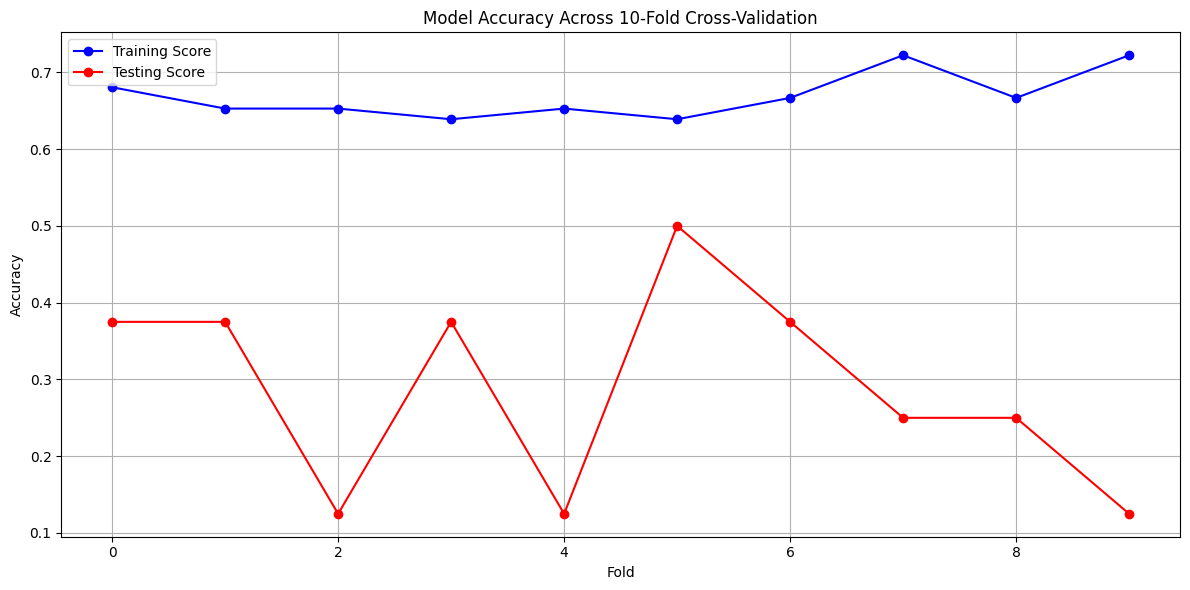

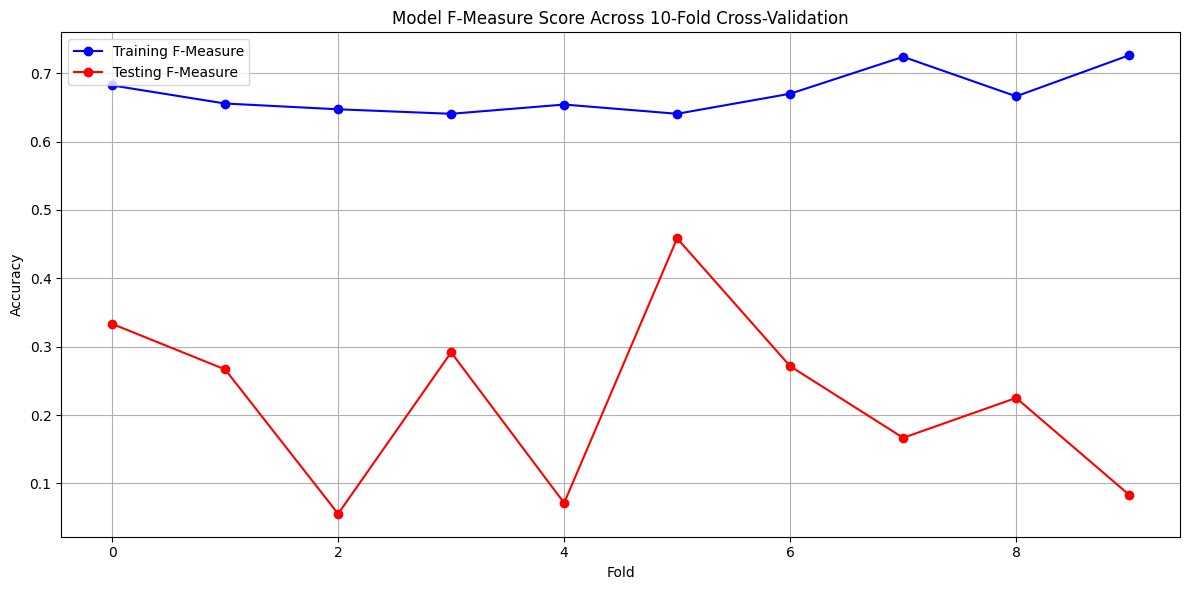

Mean Training Accuracy: 0.66944
Mean Testing Accuracy: 0.2875
Mean Training F-Measure Score: 0.67062
Mean Testing F-Measure Score: 0.22234


In [15]:
#Visualize and compare accuracy for different K values
plt.figure(figsize = (12, 6))

plt.plot(cv_results['train_accuracy'], label='Training Score', color='blue', marker='o')
plt.plot(cv_results['test_accuracy'], label='Testing Score', color='red', marker='o')

plt.title('Model Accuracy Across 10-Fold Cross-Validation')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

#Visualize and compare accuracy for different F scores
plt.figure(figsize = (12, 6))

plt.plot(cv_results['train_f1_weighted'], label='Training F-Measure', color='blue', marker='o')
plt.plot(cv_results['test_f1_weighted'], label='Testing F-Measure', color='red', marker='o')

plt.title('Model F-Measure Score Across 10-Fold Cross-Validation')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

# Print average accuracy scores
print("Mean Training Accuracy:", round(np.mean(train_accuracy), 5))
print("Mean Testing Accuracy:", round(np.mean(test_accuracy), 5))
print("Mean Training F-Measure Score:", round(np.mean(train_f1), 5))
print("Mean Testing F-Measure Score:", round(np.mean(test_f1), 5))